In [30]:

"""
Figures for results of rooftop mapping in Washington D.C.

Figure 1. Study Area Map

Figure 2. ...

Figure 3. ...

Figure 4. ...

Figure 5. ...

Figure 6. ...


"""

import os
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep
import seaborn as sns
import matplotlib as mpl

from matplotlib import pyplot as plt

%matplotlib inline

print(os.getcwd())

projdir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/'

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Ready!")


/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/code
Ready!


## Fig. 1: Study area map and distribution of training data

- 1a) Distribution of roof material classes
- 1b) Map of the study region
- 1c) Distribution of building sizes by roof material

In [21]:
# Load the footprint data
fp = os.path.join(projdir, 'data/spatial/mod/dc_data/training/dc_data_reference_centroids.gpkg')
footprints = gpd.read_file(fp)

# Merge the shingle classes (wood shingle and shingle)
merge = {'WS': 'WSH', 'SH': 'WSH'}
footprints['class_code'] = footprints['class_code'].replace(merge)
footprints.head()

,class_code,areaUTMsqft,uid,description,geometry
0,CS,357.783709,1CS,Composition Shingle,POINT (324219.172 4313566.126)
1,CS,918.640862,2CS,Composition Shingle,POINT (324610.477 4311715.754)
2,CS,1383.414170,3CS,Composition Shingle,POINT (327261.743 4300373.479)
3,CS,836.410297,4CS,Composition Shingle,POINT (333611.213 4306261.623)
4,CS,330.514264,5CS,Composition Shingle,POINT (326485.114 4300942.688)


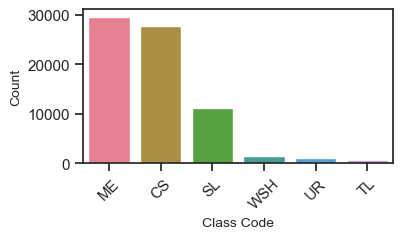

In [40]:
# Count the occurrences of each class_code
class_counts = footprints['class_code'].value_counts()

# Count the occurrences of each class_code
class_counts = footprints['class_code'].value_counts().reset_index()
class_counts.columns = ['class_code', 'count']

# Create a unique color palette for the number of unique classes
unique_classes = class_counts['class_code']
class_palette = sns.color_palette("husl", len(unique_classes))  # Husl or any other palette

# Plot the bar chart with unique colors
plt.figure(figsize=(4, 2))
sns.barplot(x='class_code', y='count', data=class_counts, hue='class_code', palette=class_palette, dodge=False, legend=False)
plt.xlabel('Class Code', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45)  # Rotate the x labels if necessary
plt.show()

In [ ]:
# Load the image data (original 8-band SuperDove imagery)
stack = os.path.join(projdir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b.tif')
stack = rxr.open_rasterio(stack, cache=False, masked=True)
shp, gt, wkt, nd = stack.shape, stack.spatial_ref.GeoTransform, stack.rio.crs, stack.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Bands: {stack.band}; \n"
    f"Band Names: {stack.attrs['long_name']}; \n"
    f"Data Type: {stack[0].dtype}")

# Create a map of the RGB
fig, ax = plt.subplots(figsize=(6, 6))
ep.plot_rgb(stack, rgb=(5, 3, 1), ax=ax)

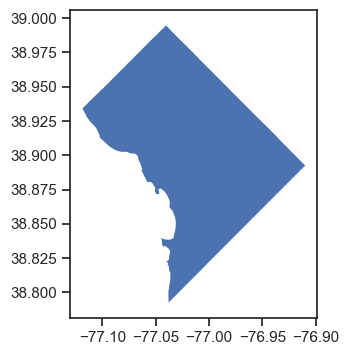

In [37]:
# Bring in the data and create simple plots

# Geospatial data (DC wards)
dc = os.path.join(projdir,'data/spatial/raw/dc_data/boundaries/district_of_columbia.gpkg')
dc = gpd.read_file(dc)

dc_ = dc.to_crs(4326)

# Plot the DC wards
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
dc_.plot(ax=ax)
plt.show()

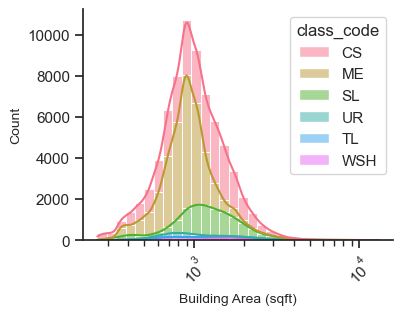

Bad pipe message: %s [b'\x00i\xf7\x91\xb6\xadWB"\x91)+\xb3&/\x80c\x89 \xb0\xda\xcaR>\xfd\xf4$\xc4\xbc\xf8^\x9d*x\xa5\x8f\x16y\xca']
Bad pipe message: %s [b'\xd1\xc1S\xa8\xc4w\x82\xee\x820\x00*\xca\xca\x13\x01\x13\x02\x13\x03\xc0,\xc0+\xcc\xa9\xc00\xc0/\xcc\xa8\xc0\n\xc0\t\xc0\x14\xc0\x13\x00\x9d\x00\x9c\x005\x00/\xc0\x08\xc0\x12\x00\n\x01\x00\x01\x89\xea\xea\x00\x00\x00\x17\x00\x00\xff\x01\x00\x01\x00\x00\n\x00\x0c\x00\n::\x00\x1d\x00\x17\x00\x18\x00\x19\x00\x0b\x00\x02\x01\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\r\x00\x18\x00\x16\x04\x03\x08\x04\x04\x01\x05\x03\x02\x03\x08\x05\x08\x05\x05\x01\x08\x06\x06\x01\x02']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x00\x003\x00+\x00)::\x00\x01\x00\x00\x1d\x00 \xb2']
Bad pipe message: %s [b' \xa3\xac\x94\xc5x\xdbA+\r\xb8\xc5X\x1f\x1a\xaf\xb66\x05\xe8/Gk\x98\xb1#\x9c|%\x00-\x00\x02\x01\x01\x00+\x00\x0b\n\xea\xea\x03\x04\x03\x03\x03\x02\x03\x01\x00\x1b\x00\x03\x02\x00\x01\n\n\x00\x01\x00\x00\

In [41]:
# Create a histogram of building size with class_code as the hue
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(4, 3))  # Adjusted the size for better visibility
sns.despine(f)

# Set the x-axis to show a logarithmic scale with appropriate ticks
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([0.1, 10, 100, 1000, 10000, 100000])
ax.set_yscale('linear')  # Keep the y-axis linear unless you want log scale

# Create a histogram colored by class_code
sns.histplot(
    data=footprints, 
    x="areaUTMsqft", 
    bins=30, 
    log_scale=True, 
    kde=True, 
    hue="class_code",  # Color by class_code
    multiple="stack",  # Stack the bars for each class
    palette=class_palette
)

# Set labels and title
ax.set_xlabel('Building Area (sqft)', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
plt.xticks(rotation=45)  # Rotate x labels if necessary
plt.show()

In [8]:

import time
import traceback
from rasterstats import zonal_stats
import numpy as np

start_time = time.time()

print(class_codes)

all_band_stats = []  # Create a list to store all zonal statistics results
# Iterate over each band in the raster
for band in range(1, abundances.shape[0] + 1): # Bands are 1-indexed
    print(f"Band {band}")
    band_data = abundances.sel(band=band).astype(np.float32).fillna(np.nan).values
    stats = zonal_stats(footprints.geometry, band_data, affine=abundances.rio.transform(), stats="mean", nodata=abundances.rio.nodata)
    mean_values = [x['mean'] for x in stats]
    all_band_stats.append(mean_values)
    
    del band_data, stats, mean_values

# Add mean values for each band as a new column in the footprints dataframe
for i, band_mean_values in enumerate(all_band_stats, 1):
    footprints[f"band_{i}_mean"] = band_mean_values

print(f"Time elapsed: {round((time.time() - start_time)/60, 1)} minutes.") 

del all_band_stats


['ME' 'CS' 'SL' 'UR' 'WS' 'SH' 'TL']
Band 1
Band 2
Band 3
Band 4
Band 5
Band 6
Band 7
Time elapsed: 2.4 minutes.


['class_code' 'areaUTMsqft' 'uid' 'description' 'geometry' 'band_1_mean'
 'band_2_mean' 'band_3_mean' 'band_4_mean' 'band_5_mean' 'band_6_mean'
 'band_7_mean']
['ME' 'CS' 'SL' 'UR' 'WS' 'SH' 'TL']


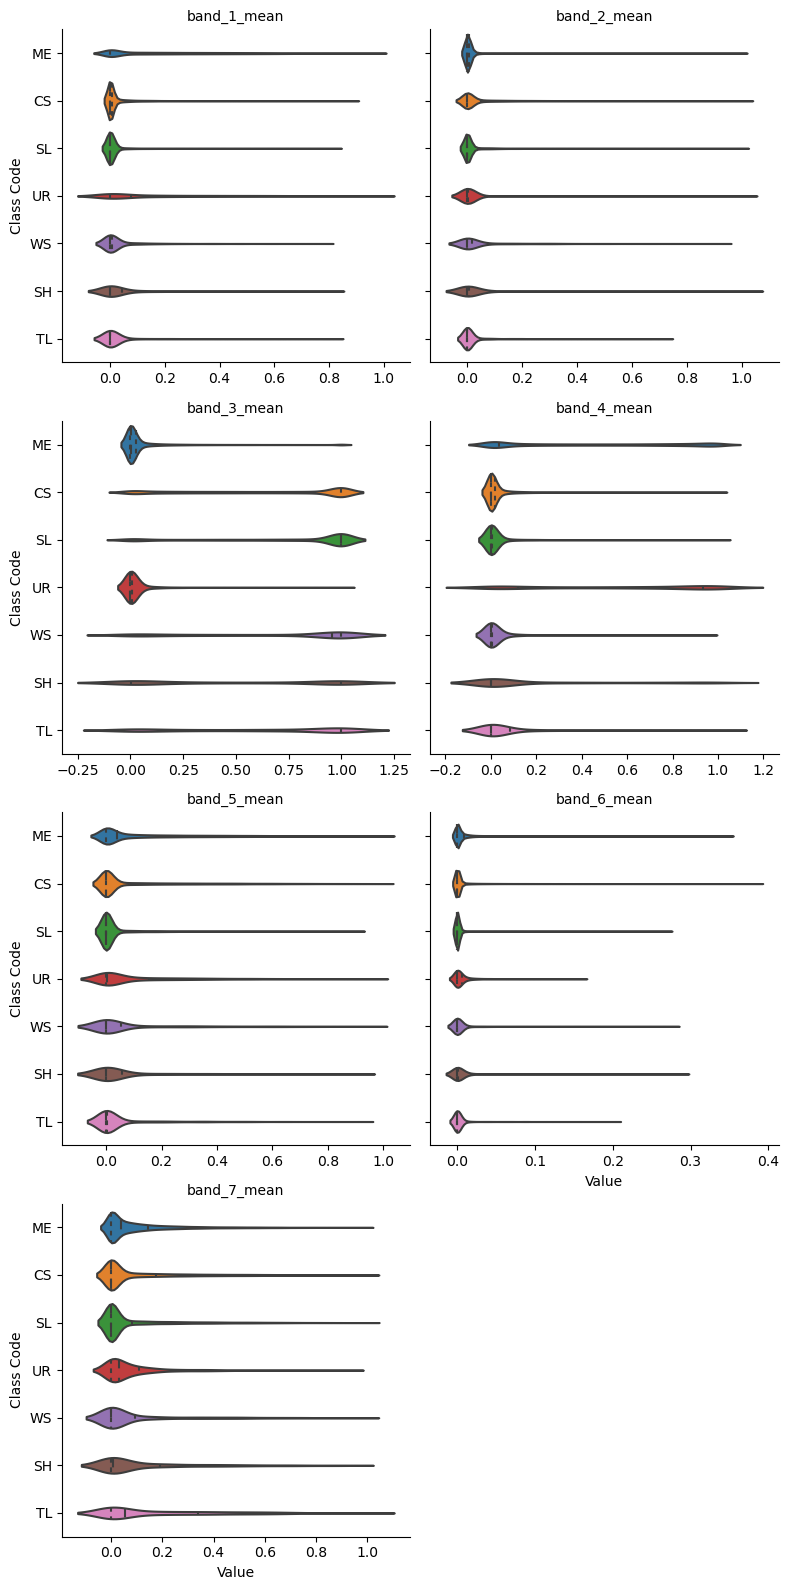

In [11]:

# Plot the distribution of abundances per material type by class

import seaborn as sns

print(footprints.columns.values)
print(class_codes)

# Melt the DataFrame to long format
footprints_m = footprints.melt(
    id_vars=['class_code'],
    value_vars=['band_1_mean','band_2_mean','band_3_mean','band_4_mean','band_5_mean','band_6_mean','band_7_mean'],
    var_name='Band',
    value_name='Value')
# Create a facet plot
g = sns.catplot(data=footprints_m, x='Value', y='class_code', col='Band',
                kind='violin', sharey=True, sharex=False, inner='quartile', col_wrap=2, height=4)
# Adjusting the titles and axis labels (if needed)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Class Code")
# Display the plot
plt.show()
